In [1]:
import xarray as xr
import xradar as xd
import datatree
from pyart.graph import cm
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import wradlib as wrl
from pandas import to_datetime
from datetime import datetime
from functools import reduce
from matplotlib import pyplot
from datatree import DataTree, open_datatree
from matplotlib.animation import FuncAnimation
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from xmovie import Movie
from IPython.display import HTML
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
warnings.simplefilter("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cluster = LocalCluster()  
client = Client(cluster)
cluster

LocalCluster(de747f21, 'tcp://127.0.0.1:39146', workers=8, threads=48, memory=48.00 GiB)

In [3]:
path = '/data/keeling/a/alfonso8/accp/zarr_radar/TAB.zarr'
path_station = './data/quetame.csv'

In [10]:
%%time
dt = open_datatree(f"{path}", engine='zarr')

CPU times: user 428 ms, sys: 366 ms, total: 794 ms
Wall time: 831 ms


In [16]:
dt['sweep_0'].times.isel(times=-1).values

numpy.datetime64('2023-07-18T23:55:24.867000000')

In [17]:
ds = dt['sweep_1'].ds.drop_isel(times=568)
ds = ds.isel(times=slice(0, 3)).sel(azimuth=slice(140, 170), range=slice(60*1e3, 120*1e3))
ds1 = dt['sweep_1'].ds.drop_isel(times=568).isel(times=slice(0, 3))

In [18]:
stations = {"GUACAPATE": {'id': 35027190, 'lat': 4.31430556, 'lon': -73.8749444}, 
            "GUTIERREZ": {'id': 35020300, 'lat': 4.25391667, 'lon': -74.0026944},
            "PALMAR": {'id': 35027200, 'lat': 4.20847222, 'lon': -73.8154167},
            "CASETEJAS": {'id': 35027210, 'lat': 4.19527778, 'lon': -73.7688889},
            "FERIAS": {'id': 35027001, 'lat': 4.40338889, 'lon': -73.9405556},
           }
cols = list(stations.keys())
parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M')
df = pd.read_csv(path_station, date_parser=parser, parse_dates=['Fecha'], index_col=["Fecha"])
df.columns = cols

<Axes: xlabel='Fecha'>

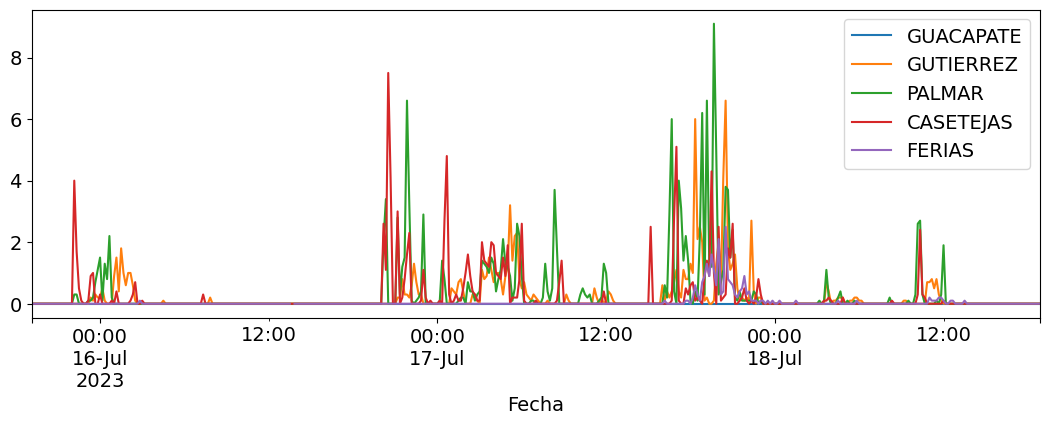

In [19]:
fig, ax = plt.subplots(figsize=(13,4))
df[(df.index > "2023-07-15 19:00") & (df.index < "2023-07-18 18:59")].plot(ax=ax)

In [20]:
df_dates = df[(df.index > "2023-07-15 19:00") & (df.index < "2023-07-18 18:59")]
df_dates.index.max()

Timestamp('2023-07-18 18:50:00')

In [21]:
proj = wrl.georef.epsg_to_osr(4326)
ds_georef = ds1.isel(times=0).copy().pipe(wrl.georef.georeference_dataset, proj=proj)

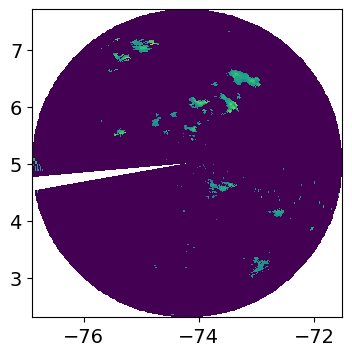

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.pcolormesh(ds_georef.x, ds_georef.y, ds_georef.DBZH)
plt.show()
# ax.pcolormesh(ds1)

In [23]:
# plt.rcParams.update({'font.size': 11})

In [24]:
%%time
# fig, (ax, ax1) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 5), dpi=150)
# gs = ax.get_gridspec()
# print(gs)
fig = plt.figure(figsize=(13, 13))
mosaic = """
    AB
    CC
    """
ax_dict = fig.subplot_mosaic(mosaic,  per_subplot_kw={
        "A": {"projection": ccrs.PlateCarree()},
        "B": {"projection": ccrs.PlateCarree()},
    })

ax = ax_dict['A']
ax1 = ax_dict['B']
ax3 = ax_dict['C']

proj_crs = xd.georeference.get_crs(ds)
cart_crs = ccrs.Projection(proj_crs)

t0 = ds.times.values[0]
print(t0)
## first plot
sc = ds.sel(times=t0).DBZH.plot(x="x", y="y", vmin=-10,
                                vmax=50, cmap="pyart_ChaseSpectral", 
                                transform=cart_crs,
                                ax=ax)
ax.set_title("")
hour = pd.to_datetime(ds.sel(times=t0).times.values).tz_localize('UTC').tz_convert('America/Bogota')
title = fig.suptitle(f"Tablazo radar - {ds.sel(times=t0).sweep_fixed_angle.values: .1f} [deg]    {hour:%Y-%m-%d %H:%M} HLC")
fig.suptitle(title)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
gl.top_labels = False
gl.right_labels = False
# ax.coastlines()
shape_feature = ShapelyFeature(Reader("./gis/shape/Departamentos.shp").geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='w')
mun = ShapelyFeature(Reader("./gis/quet/muni.shp").geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='w')

dren = ShapelyFeature(Reader("./gis/dren/Drenajes.shp").geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='w')

sen = ShapelyFeature(Reader("./gis/dren/sencillo.shp").geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='w')
ax.add_feature(mun, edgecolor='m')
ax.add_feature(shape_feature, edgecolor='w')
ax.add_feature(dren, edgecolor='blue', lw=0.5)
ax.add_feature(sen, edgecolor='blue', lw=0.5)

ax.scatter(-73.8726, 4.3326, transform=ccrs.PlateCarree(), c='#00FF00', s=8, zorder=10)
ax.set_aspect('equal', 'datalim')


## Second plot
z_lin = 10 ** (0.1 *ds.sel(times=t0).DBZH)
r_total = ((0.0376 * z_lin ** 0.6112) * (5 / 12))
p = ax1.pcolormesh(ds.x.values, ds.y.values, r_total,  transform=cart_crs, vmin=0, vmax=100, cmap='magma')
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
gl1.top_labels = False
gl1.right_labels = False
gl1.left_labels = False

ax1.add_feature(shape_feature, edgecolor='w')
plt.colorbar(p, ax=ax1, label='Total rainfall rate [mm]')
ax1.scatter(-73.8726, 4.3326, transform=ccrs.PlateCarree(), c='c', s=8, zorder=10)
ax1.set_aspect('equal', 'datalim')
ax1.add_feature(mun, edgecolor='m')
ax1.add_feature(sen, edgecolor='b', lw=0.5)
ax1.add_feature(dren, edgecolor='blue', lw=0.5)
df_dates.plot(ax=ax3)
ax3.set_ylabel(r"$Precip \  [mm]$")
ax3.set_xlim(df_dates.index.min(), df_dates.index.max())

# ax.set_title("Lluvia acumulada en 72 horas")

def update_plot(t):
    date = pd.to_datetime(t)
    # ser = df[(df.index > "2023-07-15 19:00") & (df.index < f"{date:%Y-%m-%d %H:%M}")]
    # series.set_array(ser.values.ravel())
    z_lin = 10 ** (0.1 *ds.sel(times=slice(t0, t)).DBZH)
    r_total = ((0.0376 * z_lin ** 0.6112) * (5 / 12)).sum('times')
    hour = pd.to_datetime(ds.sel(times=t).times.values).tz_localize('UTC').tz_convert('America/Bogota')
    p.set_array(r_total.values.ravel())
    sc.set_array(ds.sel(times=t).DBZH.values.ravel())
    fig.suptitle(f"Tablazo radar - {ds.sel(times=t).sweep_fixed_angle.values: .1f} [deg]    {hour:%Y-%m-%d %H:%M} HLC")

ani = FuncAnimation(fig, update_plot, frames=ds.times.values, interval=100, blit=False)
plt.close()
display(HTML(ani.to_html5_video()))

2023-07-16T00:00:52.311000000


CPU times: user 2.61 s, sys: 1.5 s, total: 4.11 s
Wall time: 3.62 s
